
                       Hypothesis Testing Decision Rules:                       

1. For each null hypothesis (H₀), we examine the p-value from statistical tests.

2. Decision Criteria:
   ● If p_value < 0.05 (significance threshold):
     - Reject the null hypothesis (H₀)
     - Conclusion: Statistically significant difference exists
     
   ● If p_value >= 0.05:
     - Fail to reject the null hypothesis (H₀)
     - Conclusion: No significant difference detected

3. Note: Statistical significance (p-value) should be considered alongside effect size
   and practical business importance.


Loading and preparing data...


C:\Users\hp\AppData\Local\Temp\ipykernel_21664\1434681887.py:33: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('file.csv')



          H₀: No risk differences across provinces          

Claim Frequency (chi-square test): p-value = 0.0000


C:\Users\hp\AppData\Local\Temp\ipykernel_21664\1434681887.py:70: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_severity = anova_table['PR(>F)'][0]


Claim Severity (ANOVA): p-value = 0.0000

----------------------------------------
REJECT H₀ - Significant risk differences exist across provinces
- Claim frequencies differ significantly
- Claim severities differ significantly
----------------------------------------


        H₀: No risk differences between postal codes        

Claim Frequency between 2000 and 122: p-value = 0.0579
Claim Severity: p-value = 0.7002

----------------------------------------
FAIL TO REJECT H₀ - No significant risk differences between 2000 and 122
----------------------------------------


       H₀: No margin differences between postal codes       

Margin difference between 2000 and 122: p-value = 0.2445

----------------------------------------
FAIL TO REJECT H₀ - No significant margin differences between 2000 and 122
----------------------------------------


          H₀: No risk differences between genders           

Claim Frequency: p-value = 0.9515
Claim Severity: p-value = 0.5680

------------

C:\Users\hp\AppData\Local\Temp\ipykernel_21664\1434681887.py:191: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Province', y='has_claim', data=df, ci=None)
C:\Users\hp\AppData\Local\Temp\ipykernel_21664\1434681887.py:209: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Gender', y='has_claim', data=gender_df, ci=None)


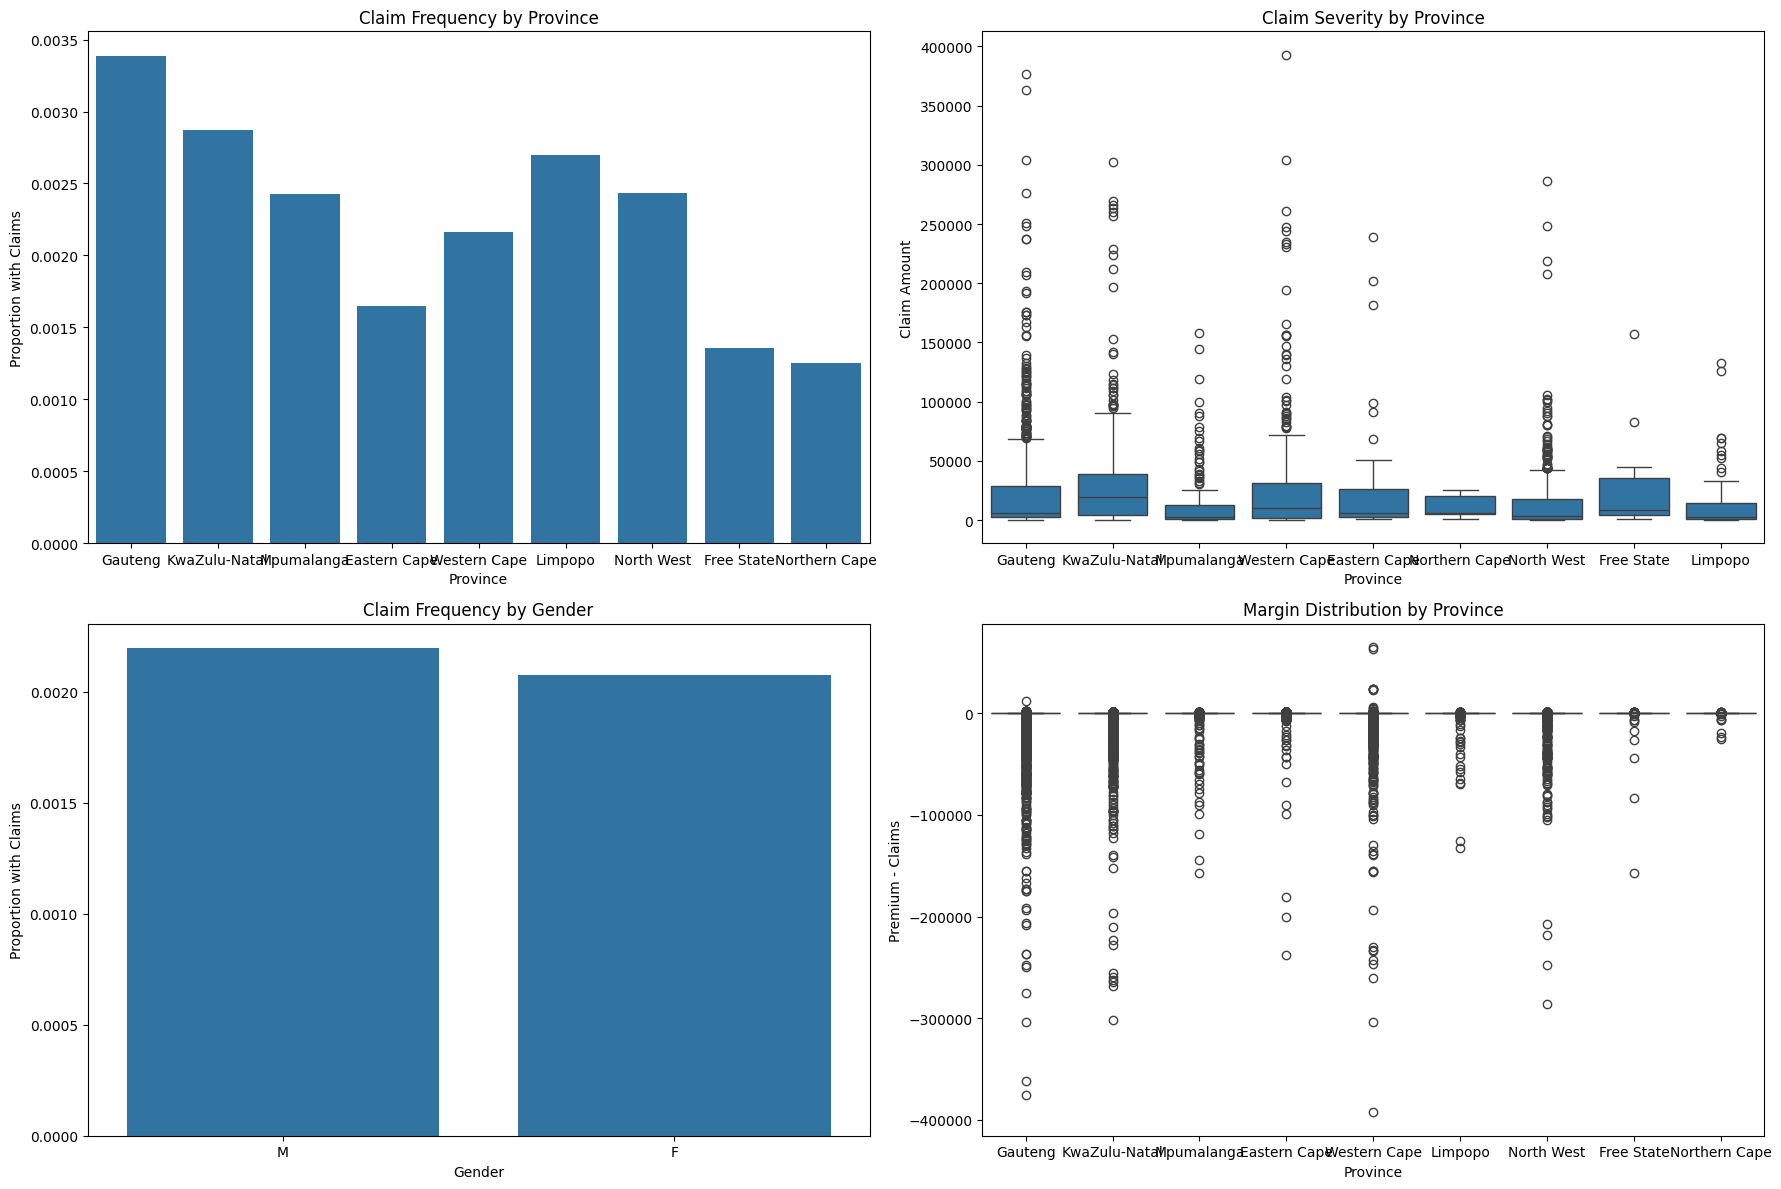


Analysis complete!


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

def print_decision_rules():
    print("\n" + "="*80)
    print("Hypothesis Testing Decision Rules:".center(80))
    print("="*80)
    print("""
1. For each null hypothesis (H₀), we examine the p-value from statistical tests.

2. Decision Criteria:
   ● If p_value < 0.05 (significance threshold):
     - Reject the null hypothesis (H₀)
     - Conclusion: Statistically significant difference exists
     
   ● If p_value >= 0.05:
     - Fail to reject the null hypothesis (H₀)
     - Conclusion: No significant difference detected

3. Note: Statistical significance (p-value) should be considered alongside effect size
   and practical business importance.
""")
    print("="*80 + "\n")

def load_and_prepare_data():
    # Load the dataset
    df = pd.read_csv('file.csv')
    
    # Drop specified columns
    columns_to_drop = ['CrossBorder', 'Citizenship', 'MaritalStatus', 
                      'CustomValueEstimate', 'NumberOfVehiclesInFleet']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Data cleaning
    df['TotalClaims'] = pd.to_numeric(df['TotalClaims'], errors='coerce').fillna(0)
    df['TotalPremium'] = pd.to_numeric(df['TotalPremium'], errors='coerce')
    df['Gender'] = df['Gender'].str.upper().str[0]  # Standardize to M/F
    df['PostalCode'] = df['PostalCode'].astype(str).str.strip().str.upper()
    
    # Create analysis variables
    df['has_claim'] = (df['TotalClaims'] > 0).astype(int)
    df['margin'] = df['TotalPremium'] - df['TotalClaims']
    
    # Filter out records with missing essential values
    df = df.dropna(subset=['TotalPremium', 'Province', 'PostalCode', 'Gender'])
    
    return df

def analyze_province_risk(df):
    print("\n" + "="*60)
    print("H₀: No risk differences across provinces".center(60))
    print("="*60)
    
    # Claim Frequency by province
    freq_table = pd.crosstab(df['Province'], df['has_claim'])
    chi2, p_freq, dof, expected = chi2_contingency(freq_table)
    print(f"\nClaim Frequency (chi-square test): p-value = {p_freq:.4f}")
    
    # Claim Severity by province
    severity_data = df[df['has_claim'] == 1]
    if len(severity_data) >= 30:  # Minimum sample size for ANOVA
        model = ols('TotalClaims ~ C(Province)', data=severity_data).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        p_severity = anova_table['PR(>F)'][0]
        print(f"Claim Severity (ANOVA): p-value = {p_severity:.4f}")
    else:
        p_severity = 1.0
        print("Insufficient claims data for severity analysis by province")
    
    # Decision
    print("\n" + "-"*40)
    if p_freq < 0.05 or p_severity < 0.05:
        print("REJECT H₀ - Significant risk differences exist across provinces")
        if p_freq < 0.05:
            print("- Claim frequencies differ significantly")
        if p_severity < 0.05:
            print("- Claim severities differ significantly")
    else:
        print("FAIL TO REJECT H₀ - No significant risk differences across provinces")
    print("-"*40 + "\n")

def analyze_postal_code_risk(df):
    print("\n" + "="*60)
    print("H₀: No risk differences between postal codes".center(60))
    print("="*60)
    
    # Compare top 2 most common postal codes
    top_zips = df['PostalCode'].value_counts().index[:2]
    if len(top_zips) < 2:
        print("\nInsufficient postal code variety for comparison")
        return
    
    zip_subset = df[df['PostalCode'].isin(top_zips)]
    
    # Claim Frequency
    freq_table = pd.crosstab(zip_subset['PostalCode'], zip_subset['has_claim'])
    chi2, p_freq, dof, expected = chi2_contingency(freq_table)
    print(f"\nClaim Frequency between {top_zips[0]} and {top_zips[1]}: p-value = {p_freq:.4f}")
    
    # Claim Severity
    severity_data = zip_subset[zip_subset['has_claim'] == 1]
    if len(severity_data) >= 20:  # Minimum sample size for t-test
        zip1_claims = severity_data[severity_data['PostalCode'] == top_zips[0]]['TotalClaims']
        zip2_claims = severity_data[severity_data['PostalCode'] == top_zips[1]]['TotalClaims']
        t_stat, p_severity = ttest_ind(zip1_claims, zip2_claims, equal_var=False)
        print(f"Claim Severity: p-value = {p_severity:.4f}")
    else:
        p_severity = 1.0
        print("Insufficient claims data for severity comparison")
    
    # Decision
    print("\n" + "-"*40)
    if p_freq < 0.05 or p_severity < 0.05:
        print(f"REJECT H₀ - Significant risk differences exist between {top_zips[0]} and {top_zips[1]}")
    else:
        print(f"FAIL TO REJECT H₀ - No significant risk differences between {top_zips[0]} and {top_zips[1]}")
    print("-"*40 + "\n")

def analyze_postal_code_margin(df):
    print("\n" + "="*60)
    print("H₀: No margin differences between postal codes".center(60))
    print("="*60)
    
    # Compare top 2 most common postal codes
    top_zips = df['PostalCode'].value_counts().index[:2]
    if len(top_zips) < 2:
        print("\nInsufficient postal code variety for comparison")
        return
    
    zip_subset = df[df['PostalCode'].isin(top_zips)]
    
    # Margin comparison
    zip1_margin = zip_subset[zip_subset['PostalCode'] == top_zips[0]]['margin']
    zip2_margin = zip_subset[zip_subset['PostalCode'] == top_zips[1]]['margin']
    t_stat, p_margin = ttest_ind(zip1_margin, zip2_margin, equal_var=False)
    print(f"\nMargin difference between {top_zips[0]} and {top_zips[1]}: p-value = {p_margin:.4f}")
    
    # Decision
    print("\n" + "-"*40)
    if p_margin < 0.05:
        print(f"REJECT H₀ - Significant margin differences exist between {top_zips[0]} and {top_zips[1]}")
    else:
        print(f"FAIL TO REJECT H₀ - No significant margin differences between {top_zips[0]} and {top_zips[1]}")
    print("-"*40 + "\n")

def analyze_gender_risk(df):
    print("\n" + "="*60)
    print("H₀: No risk differences between genders".center(60))
    print("="*60)
    
    # Filter to only M and F genders
    gender_df = df[df['Gender'].isin(['M', 'F'])]
    
    # Claim Frequency
    freq_table = pd.crosstab(gender_df['Gender'], gender_df['has_claim'])
    chi2, p_freq, dof, expected = chi2_contingency(freq_table)
    print(f"\nClaim Frequency: p-value = {p_freq:.4f}")
    
    # Claim Severity
    severity_data = gender_df[gender_df['has_claim'] == 1]
    if len(severity_data) >= 20:
        male_claims = severity_data[severity_data['Gender'] == 'M']['TotalClaims']
        female_claims = severity_data[severity_data['Gender'] == 'F']['TotalClaims']
        t_stat, p_severity = ttest_ind(male_claims, female_claims, equal_var=False)
        print(f"Claim Severity: p-value = {p_severity:.4f}")
    else:
        p_severity = 1.0
        print("Insufficient claims data for severity comparison")
    
    # Decision
    print("\n" + "-"*40)
    if p_freq < 0.05 or p_severity < 0.05:
        print("REJECT H₀ - Significant risk differences exist between genders")
    else:
        print("FAIL TO REJECT H₀ - No significant risk differences between genders")
    print("-"*40 + "\n")

def visualize_results(df):
    print("\nGenerating visualizations...")
    
    plt.figure(figsize=(18, 12))
    
    # Claim Frequency by Province
    plt.subplot(2, 2, 1)
    sns.barplot(x='Province', y='has_claim', data=df, ci=None)
    plt.title('Claim Frequency by Province')
    plt.ylabel('Proportion with Claims')
    
    # Claim Severity by Province
    plt.subplot(2, 2, 2)
    severity_data = df[df['has_claim'] == 1]
    if not severity_data.empty:
        sns.boxplot(x='Province', y='TotalClaims', data=severity_data)
        plt.title('Claim Severity by Province')
        plt.ylabel('Claim Amount')
    else:
        plt.text(0.5, 0.5, 'No claim data available', ha='center')
        plt.title('Claim Severity by Province (No Data)')
    
    # Claim Frequency by Gender
    plt.subplot(2, 2, 3)
    gender_df = df[df['Gender'].isin(['M', 'F'])]
    sns.barplot(x='Gender', y='has_claim', data=gender_df, ci=None)
    plt.title('Claim Frequency by Gender')
    plt.ylabel('Proportion with Claims')
    
    # Margin Distribution by Province
    plt.subplot(2, 2, 4)
    sns.boxplot(x='Province', y='margin', data=df)
    plt.title('Margin Distribution by Province')
    plt.ylabel('Premium - Claims')
    
    plt.tight_layout()
    plt.show()

def main():
    # Print decision rules first
    print_decision_rules()
    
    # Load and prepare data
    print("Loading and preparing data...")
    df = load_and_prepare_data()
    
    # Run analyses
    analyze_province_risk(df)
    analyze_postal_code_risk(df)
    analyze_postal_code_margin(df)
    analyze_gender_risk(df)
    
    # Generate visualizations
    visualize_results(df)
    
    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()